<a href="https://colab.research.google.com/github/jnsbrdbr/thesis/blob/thesis/part5_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.8.0


In [2]:
import keras
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [4]:
!pip install --upgrade tables

In [5]:
with pd.HDFStore('/content/drive/MyDrive/1000/part2_result',  mode='r') as newstore:
    result = newstore.select('result')

In [6]:
#final data
print(result)

             0         1         2  ...         8         9  label
0    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
1    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
2    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
3    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
4    -1.680599 -3.061217 -0.040984  ...  0.006186  0.002988      1
...        ...       ...       ...  ...       ...       ...    ...
1315 -1.680599 -3.061217 -0.040984  ... -0.035323 -0.015205      0
1316 -1.680599 -3.061217 -0.040984  ... -0.012077 -0.016767      0
1317 -1.680599 -3.061217 -0.040984  ... -0.011761 -0.013474      0
1318 -1.680599 -3.061217 -0.040984  ...  0.004503  0.113459      0
1319 -1.680599 -3.061217 -0.040984  ... -0.022880  0.001418      0

[1320 rows x 71 columns]


In [7]:
#divide data in to data_label and non_data label

import copy
result_nonlabel=copy.deepcopy(result)
del result_nonlabel['label']
X=result_nonlabel
y=result.label

In [8]:
#splitting data in to test and train...

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y ,random_state=42,test_size=0.3)#

In [9]:
print('shape of x_train is:',X_train.shape)
print('shape of x_test is:',X_test.shape)

shape of x_train is: (924, 70)
shape of x_test is: (396, 70)


In [10]:
max(X_train.max())

7454.516836076623

In [11]:
min(X_train.min())

-127.3838709715454

In [12]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [13]:
make_latent_samples(1, 300) # generates one sample

array([[ 1.69527326, -0.27140359,  0.25912621,  1.34047577,  2.20813397,
        -0.86527675, -0.41923594, -0.93972952, -1.78169582,  0.57076116,
         2.18192793, -0.24813576,  0.26264897, -0.86948185,  0.61998472,
         0.470335  ,  0.06681726, -0.7031141 , -0.31293981, -0.43943532,
        -0.49188264, -1.38447374,  0.44534554,  0.08433632,  0.70405728,
        -0.04431827,  1.37653153,  0.17781185,  1.83264083, -2.07522844,
        -1.35807156,  0.61469868,  1.29770253,  1.26517325, -0.35341965,
        -0.38792393,  0.63087227, -0.49441633, -0.5752109 ,  2.09140427,
        -0.87331446,  0.36311955, -0.80724503, -0.57790746, -1.65499071,
         0.27963624,  2.0461015 , -0.25750338, -0.4847694 , -0.21075079,
        -0.8238548 ,  1.88295885,  0.59831692, -0.30487945, -0.88911031,
         0.34475465,  1.36022375,  0.17219956,  1.9502211 , -0.52590528,
        -1.70575292, -0.33287571, -0.17261049, -0.945977  ,  0.98251541,
        -0.02611202, -0.18906395, -0.40179868, -0.1

In [14]:
generator = Sequential([
    Dense(256, input_shape=(300,)),
    LeakyReLU(alpha=0.02),
    BatchNormalization(momentum=0.6),
    Dense(512),
    LeakyReLU(alpha=0.02),
    BatchNormalization(momentum=0.6),
    #Dense(1024),
    #LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.5),
    Dense(70),
    Activation('tanh')
], name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               77056     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                         

In [15]:
discriminator = Sequential([
    Dense(128, input_shape=(70,)),
    LeakyReLU(alpha=0.02),
    BatchNormalization(momentum=0.6),
    Dense(64),
    LeakyReLU(alpha=0.02),
    BatchNormalization(momentum=0.6),
    Dense(32),
    LeakyReLU(alpha=0.02),
    #Dense(16),
    #LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    Dense(1),
    Activation('sigmoid')
], name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               9088      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                     

In [16]:
# maintain the same shared weights with the generator and the discriminator.
gan = Sequential([
    generator,
    discriminator
])

gan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 70)                247622    
                                                                 
 discriminator (Sequential)  (None, 1)                 20225     
                                                                 
Total params: 267,847
Trainable params: 265,927
Non-trainable params: 1,920
_________________________________________________________________


In [17]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [18]:
make_trainable(discriminator, False)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               9088      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                     

In [19]:
make_trainable(discriminator, True)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               9088      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                     

In [20]:
def make_simple_GAN(sample_size, 
                    g_hidden_size_1,
                    g_hidden_size_2,
                    g_hidden_size_3,
                    d_hidden_size_1,
                    d_hidden_size_2, 
                    d_hidden_size_3,
                    d_hidden_size_4,
                    leaky_alpha, 
                    g_learning_rate,
                    d_learning_rate):
    K.clear_session()
    
    generator = Sequential([
        Dense(g_hidden_size_1, input_shape=(sample_size,)),
        LeakyReLU(alpha=leaky_alpha),
        BatchNormalization(momentum=0.6),
        Dense(g_hidden_size_2),
        LeakyReLU(alpha=leaky_alpha),
        BatchNormalization(momentum=0.6),
        #Dense(g_hidden_size_3),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.5),
        Dense(70),        
        Activation('tanh')
    ], name='generator')    

    discriminator = Sequential([
        Dense(d_hidden_size_1, input_shape=(70,)),
        LeakyReLU(alpha=leaky_alpha),
        BatchNormalization(momentum=0.6),
        Dense(d_hidden_size_2),
        LeakyReLU(alpha=leaky_alpha),
        BatchNormalization(momentum=0.6),
        Dense(d_hidden_size_3),
        LeakyReLU(alpha=leaky_alpha),
        #Dense(d_hidden_size_4),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.5),
        Dense(1),
        Activation('sigmoid')
    ], name='discriminator')    
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator 

In [21]:
from sklearn import preprocessing
def preprocess(x):
   x = preprocessing.scale(x)
   return x

In [22]:
X_train_real = np.array(preprocess(X_train))
X_test_real  = np.array(preprocess(X_test))

In [23]:
while(False):

  def deprocess(x):
    x = (x / 2 + 1) * 7454.516836076623
    x = np.clip(x, -127.3838709715454, 7454.516836076623)
    x = np.uint8(x)
    x = x.reshape(-1, 70)
    return x

In [24]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [25]:
y_real_10, y_fake_10 = make_labels(10)

y_real_10, y_fake_10

(array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]), array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

In [26]:
# hyperparameters
sample_size     = 100     # latent sample size (i.e., 100 random numbers)
g_hidden_size_1 = 256
g_hidden_size_2 = 128
g_hidden_size_3 = 128
d_hidden_size_1 = 128
d_hidden_size_2 = 64
d_hidden_size_3 = 32
d_hidden_size_4 = 16
leaky_alpha     = 0.02
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.001   # learning rate for the discriminator
epochs          = 150
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1


In [27]:
# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_simple_GAN(
    sample_size, 
    g_hidden_size_1, 
    g_hidden_size_2,
    g_hidden_size_3, 
    d_hidden_size_1, 
    d_hidden_size_2,
    d_hidden_size_3,
    d_hidden_size_4,
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)


losses = []
losses1 = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
   # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))

    #d_acc_real = discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
    #d_acc_fake = discriminator.train_on_batch(X_batch_fake, y_train_fake)
    #d_acc  = 0.5 * (d_acc_real + d_acc_fake)

    #losses1.append(( d_acc))
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f} ".format(
        e+1, epochs, d_loss, g_loss)) #Discriminator acc: {:>6.4f}:,d_acc

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch:   1/150 Discriminator Loss: 0.8718 Generator Loss: 0.8518 
Epoch:   2/150 Discriminator Loss: 0.7766 Generator Loss: 1.0198 
Epoch:   3/150 Discriminator Loss: 0.6054 Generator Loss: 1.3765 
Epoch:   4/150 Discriminator Loss: 0.4057 Generator Loss: 1.9458 
Epoch:   5/150 Discriminator Loss: 0.3394 Generator Loss: 2.1634 
Epoch:   6/150 Discriminator Loss: 0.3024 Generator Loss: 2.4789 
Epoch:   7/150 Discriminator Loss: 0.3070 Generator Loss: 2.5208 
Epoch:   8/150 Discriminator Loss: 0.3643 Generator Loss: 2.6359 
Epoch:   9/150 Discriminator Loss: 0.3418 Generator Loss: 2.9757 
Epoch:  10/150 Discriminator Loss: 0.2884 Generator Loss: 2.8383 
Epoch:  11/150 Discriminator Loss: 0.3967 Generator Loss: 3.0591 
Epoch:  12/150 Discriminator Loss: 0.5702 Generator Loss: 3.4295 
Epoch:  13/150 Discriminator Loss: 0.2953 Generator Loss: 3.6572 
Epoch:  14/150 Discriminator Loss: 0.2138 Generator Loss: 3.2378 
Epoch:  15/150 Discriminator Loss: 0.7694 Generator Loss: 3.5637 
Epoch:  16

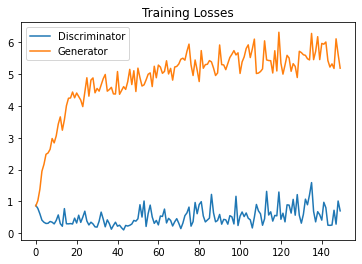

In [28]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

In [29]:
latent_samples = make_latent_samples(20, sample_size)
generated_digits = generator.predict(latent_samples)

In [30]:
for i in range(20):
    node = (generated_digits[i])
print(node)

[-0.9835415   0.32259512 -0.8546495  -0.2939674  -0.33715367 -0.1495471
  0.99021757 -0.2277357  -0.14605159 -0.17783909  0.3694085  -0.9466934
  0.36528003 -0.9842521   0.34324554 -0.65260535  0.7495523  -0.42668173
  0.96217555  0.9356957  -0.99661386  0.9122793   0.33265406 -0.66994554
  0.10025528 -0.9569357   0.5552302   0.16082887 -0.96735185  0.42164403
 -0.9885032   0.9763026  -0.9119174  -0.86006904 -0.9885817  -0.61424464
 -0.89582866 -0.37775713  0.17734161 -0.44050732  0.64922434  0.99721783
 -0.38076824  0.3352041   0.57002753  0.9707241   0.9644954   0.65004325
 -0.00233589 -0.58330715 -0.24027885 -0.33745533 -0.48985285  0.87425315
 -0.9796134   0.9648528  -0.8409719   0.9272181  -0.59677196 -0.8452587
 -0.5958382  -0.9551507   0.9985471  -0.89523613 -0.69791627 -0.98128605
  0.5545585   0.992081   -0.6401333   0.98111606]


In [31]:
rr = discriminator.predict_on_batch(X_test_real)

In [32]:
rr

array([[9.0657061e-01],
       [9.0657055e-01],
       [9.2768192e-01],
       [9.9103522e-01],
       [9.8813492e-01],
       [9.6617699e-01],
       [9.6580970e-01],
       [8.7411535e-01],
       [8.7505364e-01],
       [9.6617699e-01],
       [8.7505323e-01],
       [8.7505329e-01],
       [9.6617693e-01],
       [9.4657832e-01],
       [7.5457734e-01],
       [9.0658808e-01],
       [9.0658820e-01],
       [9.0657055e-01],
       [1.2636691e-02],
       [9.1019416e-01],
       [8.7411529e-01],
       [9.0657055e-01],
       [3.3693379e-07],
       [9.9311733e-01],
       [6.1963880e-01],
       [9.0657067e-01],
       [9.0657055e-01],
       [1.1857175e-04],
       [8.7507975e-01],
       [9.4634438e-01],
       [9.6588999e-01],
       [9.2768157e-01],
       [9.0658832e-01],
       [9.4657832e-01],
       [8.7505341e-01],
       [9.1019505e-01],
       [8.7505352e-01],
       [9.8677349e-01],
       [9.6617699e-01],
       [9.6580976e-01],
       [7.8653425e-02],
       [9.883686

In [33]:
rr.min()

3.369338e-07

In [34]:
rr.max()

0.99996704

In [35]:
y_test

678     1
693     1
610     1
49      1
1291    0
       ..
141     1
820     1
613     1
543     1
139     1
Name: label, Length: 396, dtype: int64

In [36]:
import keras
#import keras_metrics

r = tf.keras.metrics.Recall()
r.update_state(y_test,rr )
r.result().numpy()


1.0

In [37]:
p=tf.keras.metrics.Precision()
p.update_state(y_test,rr )
p.result().numpy()

0.7915567